# Applying SVC and SGDClassifier on TFIDF Word2vec

This ipynb file contains the code for-

* GridSearchCV on SVC for TFIDF Word2vec
* RandomizedSearchCV on SVC for TFIDF Word2vec
* GridSearchCV on SGDClassifier for TFIDF Word2vec

In [6]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [7]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the sample that we have saved in TFIDF, for all preprocessing task refer to TFIDF

In [8]:
sample_data=pd.read_csv('sample_svm.csv')# reading sample that we have saved in TFIDF

In [12]:
sample_data=sample_data.iloc[:25000] 

#### Observation-
* 50k points takes lots of hours to run thus we have used just 25000 data points 

In [13]:
#taking the test data seperate from all other
from sklearn.model_selection import train_test_split
X, x_test, y_train, y_test=train_test_split(sample_data['Cleaned_text'], sample_data['Score'], test_size=0.3, shuffle=False) #splitting the data

In [31]:
# this function predicting accuracy, confusion matrix and classification report

def svm_plot(clf, x_train, y_train, x_test, y_test):
          
    #predicting y and accuracy
    y_pred=clf.predict(x_test)
    accu=accuracy_score(y_pred,y_test)*100
    print('accuracy=',accu)
    print('**********************************************************************\n')
    
    #confusion matrix
    t=confusion_matrix(y_pred,y_test)
    print('confusion matrix--')
    #print(t)
    #print('**********************************************************************')
    sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    print('**********************************************************************\n')
    
    # finding TPR , TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    print('**********************************************************************\n')
    
    
    #classification report
    print(classification_report(y_pred,y_test))
    print('**********************************************************************\n')
    
    
    return accu, TNR, TPR, FPR, FNR

In [10]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [11]:
#loading the GoogleNews word2vec model(able to read bin.gz file directly, no need to extract)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2018-09-17 03:28:48,901 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-09-17 03:31:45,227 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [14]:

#getting the list of sentences in a 'list'
i=0

list_of_sentences=[]
for sent in X.values:
    filtered_sentence=[]    
    for w in sent.split():
        #w=w.decode('utf-8')
        if (w==sent.split()[0]):
            w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [15]:
words=list(model.wv.vocab)
print(len(words))

3000000


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [17]:
features=tfidf.get_feature_names()
len(features)
#features

15151

In [18]:
#calculating tf-idf w2vec for training data
tfidf_vectors = []; 
row=0;
for sentence in list_of_sentences: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1

In [19]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[1622,
 1695,
 1960,
 2226,
 4436,
 4524,
 4710,
 5927,
 6569,
 8073,
 11064,
 11656,
 11967,
 12760,
 13050]

In [20]:

y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)



In [21]:
#calculating tf-idf w2vec for testing data
x_test_tf_word = []; 
row=0;
for sentence in x_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [22]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
z

[5388, 6507]

In [23]:
x_test_tf_word=np.delete(x_test_tf_word, z , axis=0)
len(x_test_tf_word)

7498

In [25]:
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)
#len(x_test_word)

In [26]:
from sklearn.preprocessing import normalize
tfidf_vectors=normalize(tfidf_vectors)
x_test_tf_word=normalize(x_test_tf_word)

## Applying GridSearchCV on SVC

In [27]:
from sklearn.svm import SVC

tscv=TimeSeriesSplit(n_splits=10)
gamma=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 'gamma':gamma}
clf=SVC()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=-1, verbose=1)

In [28]:
# fitting the model
import pickle
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
pickle.dump(clf,open('svm_tfw_grid.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs
Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 73.5min finished


duration =  1:15:23.077008


In [29]:
# best value of C
c=clf.best_estimator_.get_params()['C']
gamma=clf.best_estimator_.get_params()['gamma']
print('best C=',c)
print('best penalty=',gamma)

best C= 10
best penalty= 0.5


accuracy= 89.31715124033074
**********************************************************************

confusion matrix--


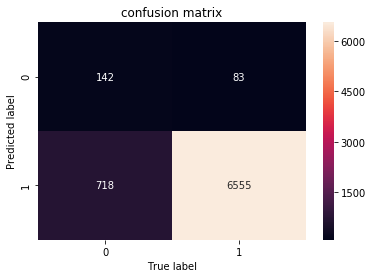

**********************************************************************

TNR= 0.16511627906976745
TPR= 0.9874962338053631
FPR= 0.8348837209302326
FNR= 0.012503766194636938
**********************************************************************

             precision    recall  f1-score   support

          0       0.17      0.63      0.26       225
          1       0.99      0.90      0.94      7273

avg / total       0.96      0.89      0.92      7498

**********************************************************************



In [34]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=tfidf_vectors, y_train=y_train_word, x_test=x_test_tf_word, y_test=y_test_word)

## Applying RandomizedSearchCV on SVC

In [36]:
from sklearn.model_selection import RandomizedSearchCV

tscv=TimeSeriesSplit(n_splits=10)
gamma=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 'gamma':gamma}
clf=SVC()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param,cv=tscv,scoring='accuracy', n_jobs=-1)

In [37]:
# fitting the model
import pickle
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
pickle.dump(clf,open('svm_tfw_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.1 µs
duration =  0:15:06.938497


In [38]:
# best value of C
c=clf.best_estimator_.get_params()['C']
gamma=clf.best_estimator_.get_params()['gamma']
print('best C=',c)
print('best penalty=',gamma)

best C= 50
best penalty= 0.001


accuracy= 88.53027473993065
**********************************************************************

confusion matrix--


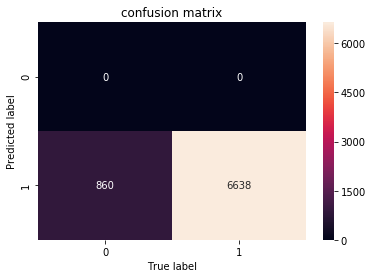

**********************************************************************

TNR= 0.0
TPR= 1.0
FPR= 1.0
FNR= 0.0
**********************************************************************

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.89      0.94      7498

avg / total       1.00      0.89      0.94      7498

**********************************************************************



In [39]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=tfidf_vectors, y_train=y_train_word, x_test=x_test_tf_word, y_test=y_test_word)

## Applying GridSearchCV on SGDClassifier

In [46]:
from sklearn.linear_model import SGDClassifier

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l1', 'l2']
param={'alpha': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'penalty':penalty}
clf=SGDClassifier()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [47]:
# fitting the model
import pickle
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
pickle.dump(clf,open('svmlin_tfw_grid.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits
duration =  0:00:22.943303


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:   22.8s finished


In [48]:
# best value of C
penalty=clf.best_estimator_.get_params()['penalty']
alpha=clf.best_estimator_.get_params()['alpha']
print('best alpha=',alpha)
print('best penalty=',penalty)

best alpha= 5e-05
best penalty= l2


accuracy= 88.85036009602561
**********************************************************************

confusion matrix--


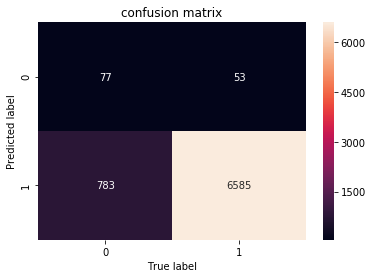

**********************************************************************

TNR= 0.08953488372093023
TPR= 0.9920156673696897
FPR= 0.9104651162790698
FNR= 0.007984332630310334
**********************************************************************

             precision    recall  f1-score   support

          0       0.09      0.59      0.16       130
          1       0.99      0.89      0.94      7368

avg / total       0.98      0.89      0.93      7498

**********************************************************************



In [49]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=tfidf_vectors, y_train=y_train_word, x_test=x_test_tf_word, y_test=y_test_word)

# Performance Table

| sno | featurization | model algo | cv algo | best C | best gamma | accuracy | TNR | TPR | f1-score |
|-----|----------------|---------------|--------------------|-------------|------------|----------|--------|--------|----------|
| 1 | Tfidf word2vec | SVC | GridSearchCV | 10 | 0.5 | 89.3171 | 0.1651 | 0.9874 | 0.92 |
| 2 | Tfidf word2vec | SVC | RandomizedSearchCV | 50 | 0.001 | 88.5302 | 0.0 | 1.0 | 0.94 |


| sno | featurization | model algo | cv algo | best alpha | best penalty | accuracy | TNR | TPR | f1-score |
|-----|----------------|---------------|--------------|------------|--------------|----------|--------|--------|----------|
| 1 | Tfidf word2vec | SGDClassifier | GridSearchCV | 5e-05 | l2 | 88.8503 | 0.0895 | 0.9920 | 0.93 |

## Observation -
* both SVC and SGDClassifier gives approximately same f1 score and accuracy
* very bad TNR